#### Setup environment

In [1]:
# %load "/Users/haleighwright/Desktop/NCEAS/pyriv/notebooks/nb_config.py"
import sys
sys.path.append("/Users/haleighwright/Desktop/NCEAS/pyriv")
sys.path.append("/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages")
import networkx as nx
import numpy as np
import sys
import geopandas as gpd
from shapely.geometry import Point
from multiprocessing import Pool

from pyriv import graph_prep as GraphBuilder
from pyriv import river_graph as RiverGraph

%matplotlib inline

In [2]:
from functools import partial
from types import *

### Retrieve the dead ends of the network
The dead ends are the nodes that have an out degree = 0

In [3]:
# to be efficient with this process, we need to assign node ID's - nodes are identified by their coord's when read in

In [4]:
def add_node_ids_copy(G):
    """
    Parameters
    snetworkx graph
    Returncopy of graph with node ID attr. added
    
    Returns a copy of the graph with node ID attr (an int) added, 
    used for finding problem nodes easier / quicker node identification
    Must use a dict with the nodes' as keys and the attributes listed
    """
    copy = G.copy()
    return add_node_ids_mutate(copy)

In [5]:
def node_to_dict(G):
    nodes = nx.nodes(G)
    #check if they have id first?
    #if nodes[0]
    temp = {}
    i = 0
    for node in nodes:
        temp[i] = node
        i = i+1
        
    return temp

In [6]:
def add_node_ids_mutate(G):
    """
    Params: networkx graph
    Return: referfence to modified graph
    
    Modifies input graph with node ID attr (an int) added, 
    used for finding problem nodes easier / quicker node identification
    Must use a dict with the nodes' as keys and the attributes listed
    """
    attr_dict = {}
    i = 0
    keys = G.nodes()
    for node in keys:
        attr_dict[node] = i
        i = i+1
    nx.set_node_attributes(G, 'ID', attr_dict)
    return G

In [7]:
def deadends_old(self):
    """
    For a directed graph, find the nodes that have out_degree == 0
    Note: this is the older, slower method
    """
    thedict = {}
    # get a dictionary of { node: out_degree }
    degdict = self.out_degree(self.nodes())
    # convert to a 2 column array of node and out_degree
    degarr = np.array(degdict.items())
    # get a boolean index of rows where out_degree==0
    dead_row_ind = (degarr[:,1]==0)

    
    for i in range(0, len(degarr)):
        if dead_row_ind[i] == True:
            thedict[allnodes[i][0]] = tuple(degarr[:,0][i])
            
    # use that index to get the nodes
    #dead_nodes = degarr[:,0][dead_row_ind]
    return thedict

In [8]:
def deadend_coords_to_keys(G, ends):
    assert type(ends) is TupleType, "collection of end nodes is not a tuple"
    ends = list(ends)
    
    
    alldict = nx.get_node_attributes(G, 'ID')
    
    keylist = []
    for i in range(0, len(ends)):
        keylist.append(alldict[ends[i]])
        
    return keylist
        
    

In [9]:
def find_missing_edges_seq(G, ends, allnodes, threshold):
    """
    Params:
    Returns: list of missing edges

    Sequential method to find missing edges. VERY VERY SLOW; use ||'zd version
    """
    for key1, node1 in deadends.iteritems():
        for key2, node2 in allnodes.iteritems():
            #print node1
            xd = node1[0] - node2[0]
            yd = node1[1] - node2[1]
            dist = np.sqrt((xd*xd + yd*yd))
            
            if key1 != key2 and dist < threshold and dist > 0:
                graph.add_edge(key1, key2)
                print("added edge from "+str(key1)+" : "+str(node1)+" to "+ str(key2)+" : "+str(node2))
                problem_points[str(cnt)+"_A"] =key1
                problem_points[str(cnt)+"_B"] =key2
                break
                
        



In [10]:
def find_missing_edges_par(ends, nodes, threshold, numproc):
    """
    Params: ends = deadends found dict, allnodes = iterable of all nodes; threshold = dist. thresh
    Returns: a list of missing edges to add where dist < thresh. b/w the deadend & other node
    
    ||'zd method to find missing edges (a CPU-bound task w/ no communication needs)
    
    Note 1: in order to pass multiple args to multiproc.'g map fcn. we use a partial 
                                                                ( req. Python >=2.7)
    Note 2: Pool.map maps a fcn over sequence (str, unicode, list, tuple, buffer, or xrange) so
                        need to convert dict to that first
    """
    assert type(ends) is ListType, "collection of end nodes is not a list"
    assert type(ends[0]) is IntType, "nodes in ends list arent referred to by their ID"
    
    assert type(nodes) is DictType, "collection of allnodes is not a dictionary"
    
    #need to convert the dict of dead ends to the correct format, which is:
    #    key: (key, (coord_x, coord_y))

    realdict = {}
    for key, val in nodes.iteritems():
        realdict[key]=(key, val)
        
    #assert type(allnodes[0]) is IntType, "first column of allnodes dictionary is not a node ID"
    #assert type(allnodes[0][0]) is TupleType, "second column of allnodes dictionary is not a coord tuple"
    
    
    if numproc < 2:
        print("Please request to run more than one concurrent process to avoid redundant work. If you wish to use "+
                +"the sequential version of this method, please do so directly.")
    else:
        
        
          
        pool = Pool(numproc)
    
        result_list = pool.map(partial(find_missing_edges_par_inner, allnodes=realdict, th=threshold), ends)
        pool.close()
        pool.join()
        
        cleaned_results = []
        #clean result list before returning or else it will have empty entries
        for entry in result_list:
            if not not entry:
                if len(entry) > 1:
                    for innerentry in entry:
                        cleaned_results.append(innerentry)
                else:
                    cleaned_results.append(entry[0])
                
        return cleaned_results 
    
    

In [11]:
def find_missing_edges_par_inner(key1, allnodes, th):
    """
    inner function for || version of finding missing edges
    """
    
    edges_to_add = []
    node1 = allnodes[key1][1]
    for i in range(0, len(allnodes)):
        key2 = allnodes[i][0]
        if key1 != key2:
            node2 = allnodes[i][1]
            xd = node1[0] - node2[0]
            yd = node1[1] - node2[1]
            dist = np.sqrt((xd*xd + yd*yd))
            if key1 != key2 and dist < th and dist > 0:
                edges_to_add.append([key1,key2])
                break
                
    return edges_to_add
    
    
    

In [12]:
def add_missing_edges(G, edges_to_add, allnodes):
    """
    Params: G = graph to add edges to; list of edges to add w/ each entry an [x,y] list
    Returns: nothing
    
    IMPORTANT: MUTATES the graph passed in
    """
    for coord in edges_to_add:
        G.add_edge(allnodes[coord[0]], allnodes[coord[1]])

In [13]:
def missing_edges_to_shp(pts, filepath, projection_code):
    """
    Params: nodes/pts describing missing edges; relative filepath .shp to write to; projection_code to convert
            coords (should match the maps you started with for overlaying purposes)
    Returns: none (writes to output file) 
    
    
    """
    pts = list(pts.values())
    kcdf = gpd.GeoDataFrame({'geometry': [Point(n) for n in pts]})
    kcdf.crs = {'init': projection_code}
    kcdf.to_file(filepath)

In [14]:
def component_stats(G, verbose):
    """
    Params: G = graph to collect stats on, verbose flag
    Returns: nothing
    
    Prints out various relevent stats about graphs concerning components
    """
    explans = {}
    if verbose == True:
        explans['weakly-connected'] = "(There is an undirected path between each pair of nodes in the directed graph)"
        explans['strongly-connected'] = "(There is a directed path between each pair of nodes in the directed graph)"
        explans['semiconnected'] = ""
    else:
        explans['weakly-connected'] = ""
        explans['strongly-connected'] = ""
        explans['semiconnected'] = ""
        
    
    print "Is the graph weakly connected "+explans['weakly-connected'] +"? "+ str(nx.is_weakly_connected(G)) 
    print "Number of weakly connected components: " + str(nx.number_weakly_connected_components(G))
    print "Is the graph semiconnected "+explans['semiconnected']+ "? " + str(nx.is_semiconnected(G))
    print "Is the graph strongly connected "+explans['strongly-connected']+ "? "+ str(nx.is_strongly_connected(G))
    
    
    
    

In [15]:
def general_stats(G):
    """
    Print general stats about graph G
    Can add more as/if needed...
    """
    print "Number of edges: "+ str(G.number_of_edges())
    print "Number of nodes: "+str(G.number_of_nodes()) 

# Test The Methods after merging with master and refactor 7/12

# Test The Methods
Go through and test the above methods to assure they all work properly

In [16]:
kusko_g = GraphBuilder.GraphBuilder('../../data/sasap/kusko_region_flowlines.gpickle')

Weighting Edges with Distances


In [17]:
kusko_g_ID = add_node_ids_copy(kusko_g.graph)

KeyboardInterrupt: 

In [ ]:
component_stats(kusko_g_ID, True)

In [ ]:
general_stats(kusko_g_ID)

In [ ]:
kusko_ends = kusko_g_ID.deadends()

In [ ]:
print kusko_ends[0]

In [ ]:
print type(kusko_ends)


In [ ]:
kusko_ends_list = deadend_coords_to_keys(kusko_g_ID, kusko_ends)

In [ ]:
print type(kusko_ends_list)
print kusko_ends_list[0]

In [ ]:
allnodesdict = node_to_dict(kusko_g_ID)


In [ ]:
missing_edges = find_missing_edges_par(kusko_ends_list, allnodesdict, 0.3, 8)

In [ ]:
cleaned_results = []
#clean result list before returning or else it will have empty entries
#added this to the missing_edges function directly
for entry in missing_edges:
            if not not entry:
                if len(entry) > 1:
                    for innerentry in entry:
                        cleaned_results.append(innerentry)
                else:
                    cleaned_results.append(entry[0])
                

In [ ]:
print cleaned_results

In [ ]:
copy_kusko2 = kusko_g_ID.copy()

In [ ]:
allnodesdict[203007]

In [ ]:
add_missing_edges(copy_kusko2, cleaned_results, allnodesdict)

In [ ]:
general_stats(copy_kusko2)

# Collect Samples for testing

In [32]:
smaller_island = gpd.read_file('../../data/sasap/highres_AK_pruned/sample_smaller_island2.shp')
larger_island = gpd.read_file('../../data/sasap/highres_AK_pruned/sample_larger_island2.shp')
smaller_island.to_file('../../data/sasap/highres_AK_pruned/sample_smaller_island-f.shp')
larger_island.to_file('../../data/sasap/highres_AK_pruned/sample_larger_island-f.shp')

In [33]:
smaller_island = GraphBuilder.GraphBuilder('../../data/sasap/highres_AK_pruned/sample_smaller_island-f.shp')
larger_island = GraphBuilder.GraphBuilder('../../data/sasap/highres_AK_pruned/sample_larger_island-f.shp')


Weighting Edges with Distances
Weighting Edges with Distances


In [34]:
smaller_is_g = smaller_island.graph
larger_is_g = larger_island.graph

In [35]:
general_stats(smaller_is_g)
component_stats(smaller_is_g, False)

general_stats(larger_is_g)
component_stats(larger_is_g, False)

Number of edges: 831
Number of nodes: 859
Is the graph weakly connected ? False
Number of weakly connected components: 28
Is the graph semiconnected ? False
Is the graph strongly connected ? False
Number of edges: 3174
Number of nodes: 3336
Is the graph weakly connected ? False
Number of weakly connected components: 162
Is the graph semiconnected ? False
Is the graph strongly connected ? False


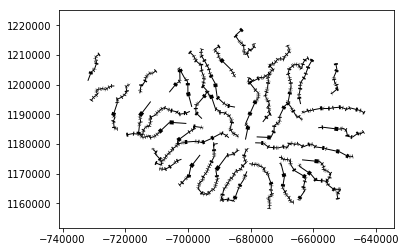

In [36]:
smaller_is_g.plot()

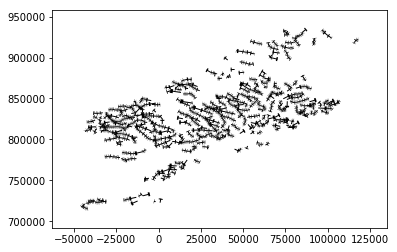

In [21]:
larger_is_g.plot()

In [22]:
larger_is_cl = gpd.read_file('../../data/sasap/NatMapCoastline3338/NatMapCoastline3338-large-is.shp')
smaller_is_cl = gpd.read_file('../../data/sasap/NatMapCoastline3338/NatMapCoastline3338-small-is.shp')

In [23]:
larger_is_cl.to_file('../../data/sasap/NatMapCoastline3338/NatMapCoastline3338-large-is-f.shp')
smaller_is_cl.to_file('../../data/sasap/NatMapCoastline3338/NatMapCoastline3338-small-is-f.shp')

In [24]:
smaller_is_cl = GraphBuilder.GraphBuilder('../../data/sasap/NatMapCoastline3338/NatMapCoastline3338-small-is-f.shp')
larger_is_cl = GraphBuilder.GraphBuilder('../../data/sasap/NatMapCoastline3338/NatMapCoastline3338-large-is-f.shp')




Weighting Edges with Distances
Weighting Edges with Distances


In [25]:
general_stats(larger_is_cl.graph)
general_stats(smaller_is_cl.graph)
component_stats(larger_is_cl.graph, False)
component_stats(smaller_is_cl.graph, 'ijd')

Number of edges: 55
Number of nodes: 55
Number of edges: 9
Number of nodes: 9
Is the graph weakly connected ? False
Number of weakly connected components: 55
Is the graph semiconnected ? False
Is the graph strongly connected ? False
Is the graph weakly connected ? False
Number of weakly connected components: 7
Is the graph semiconnected ? False
Is the graph strongly connected ? False


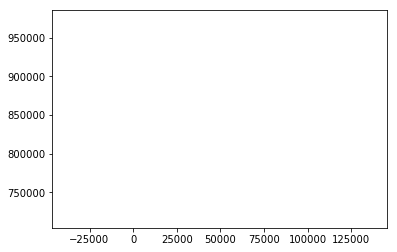

In [26]:
larger_is_cl.graph.plot()

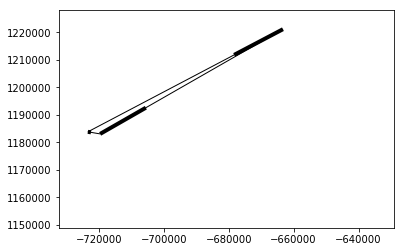

In [27]:
smaller_is_cl.graph.plot()

In [28]:
smaller_is_cl.graph = add_node_ids_copy(smaller_is_cl.graph)
larger_is_cl.graph = add_node_ids_copy(larger_is_cl.graph)


In [29]:
#smaller_missing_edges = find_missing_edges_par(deadend_coords_to_keys(smaller_is_cl.graph, smaller_is_cl.graph.deadends()), node_to_dict(smaller_is_cl.graph), 1.0, 8)
#larger_missing_edges = find_missing_edges_par(deadend_coords_to_keys(larger_is_cl.graph, larger_is_cl.graph.deadends()), node_to_dict(larger_is_cl.graph), 1.0, 8)

### Why are the coastlines like this ? need to investigate : 

In [30]:

print nx.degree_histogram(smaller_is_cl.graph)
print nx.degree_histogram(larger_is_cl.graph)
print smaller_is_cl.graph.out_degree().values()
print smaller_is_cl.graph.in_degree().values()
print larger_is_cl.graph.out_degree().values()
print larger_is_cl.graph.in_degree().values()

[0, 0, 9]
[0, 0, 55]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [31]:
nx.get_node_attributes(smaller_is_cl.graph)[0]

TypeError: get_node_attributes() takes exactly 2 arguments (1 given)